# Target Strength vs Non-dimensional Parameter ka

This notebook analyzes the target strength (TS) of a 4 mm diameter methane bubble as a function of the non-dimensional parameter **ka**



## Import Required Libraries

Import necessary libraries including NumPy, Matplotlib, and acoustic scattering libraries.

In [1]:
# Standard scientific computing imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add project root to path for imports
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# Import SeaEcho modules
from utils.SeaEcho_water import seawater
from utils.SeaEcho_gas_bubble import air_bubble

# Import the three specific bubble scattering models  
from Bubble.models.breathing_model import calculate_breathing_ts
from Bubble.models.thuraisingham_model import calculate_thuraisingham_ts
from Bubble.models.modal_solution import calculate_modal_ts

# Set up plotting parameters with larger fonts
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

print("✓ All required modules imported successfully")


✓ All required modules imported successfully


## Define Bubble Parameters

Set up the bubble radius (2 mm), material properties (methane), and environmental conditions for the scattering calculations.

In [2]:
# Environmental parameters for seawater
T = 20.0    # Temperature (°C)
z = 10.0    # Depth (m)  
S = 35.0    # Salinity (psu)

# Bubble parameters
bubble_diameter = 4.0e-3  # 4mm diameter in meters
bubble_radius = bubble_diameter / 2

# Create seawater and air bubble objects (approximating methane properties)
water = seawater(T, z, S)
c = water.sound_speed()  # Sound speed in seawater

# Create air bubble object 
bubble = air_bubble(water, T, z, S, bubble_diameter)

print(f"Bubble Parameters:")
print(f"  Diameter: {bubble_diameter*1e3:.1f} mm")
print(f"  Radius: {bubble_radius*1e3:.1f} mm")


print(f"\nEnvironmental Parameters:")
print(f"  Temperature: {T:.1f} °C")
print(f"  Depth: {z:.1f} m") 
print(f"  Salinity: {S:.1f} psu")
print(f"  Sound speed: {c:.1f} m/s")

print(f"\nBubble Properties:")
print(f"  Pressure inside bubble: {bubble.Pg/1e5:.3f} bar")
print(f"  Density inside bubble: {bubble.rho:.4f} kg/m³")
print(f"  Specific heat ratio: {bubble.gamma:.2f}")

print(f"\n✓ Seawater and air bubble objects created successfully")

Bubble Parameters:
  Diameter: 4.0 mm
  Radius: 2.0 mm

Environmental Parameters:
  Temperature: 20.0 °C
  Depth: 10.0 m
  Salinity: 35.0 psu
  Sound speed: 1521.7 m/s

Bubble Properties:
  Pressure inside bubble: 1.993 bar
  Density inside bubble: 2.3677 kg/m³
  Specific heat ratio: 1.40

✓ Seawater and air bubble objects created successfully


## Calculate Wavenumber and ka Parameter

Calculate the wavenumber from frequency and sound speed, then compute the non-dimensional parameter ka = wavenumber * bubble_radius.

In [3]:
# Define frequency range to cover ka range from 0.001 to 20
# For 4mm bubble (radius = 0.002 m), calculate required frequencies:
# ka = k * r = (2πf/c) * r
# f = ka * c / (2π * r)

# Target ka range: 0.001 to 20
ka_min_target = 0.001
ka_max_target = 20.0

# Calculate corresponding frequencies for 4mm bubble
f_min = ka_min_target * c / (2 * np.pi * bubble_radius) / 1000  # Convert to kHz
f_max = ka_max_target * c / (2 * np.pi * bubble_radius) / 1000  # Convert to kHz
n_points = 1000  # Number of frequency points

print(f"Target ka range: {ka_min_target} to {ka_max_target}")
print(f"Calculated frequency range: {f_min:.4f} kHz to {f_max:.3f} kHz")

# Create logarithmic frequency array for better coverage of ka range
frequencies = np.logspace(np.log10(f_min), np.log10(f_max), n_points)  # kHz

# Calculate wavenumber and ka for each frequency
wavenumber = 2 * np.pi * frequencies * 1000 / c  # k = 2πf/c, convert kHz to Hz
ka = wavenumber * bubble_radius  # Non-dimensional parameter

print(f"\nActual Results:")
print(f"  Min frequency: {frequencies.min():.4f} kHz → ka = {ka.min():.4f}")
print(f"  Max frequency: {frequencies.max():.3f} kHz → ka = {ka.max():.1f}")
print(f"  Number of points: {n_points}")
print(f"")
print(f"Acoustic Scattering Regimes:")
print(f"  Rayleigh regime (ka << 1): ka < 0.3")
print(f"  Resonance regime (ka ≈ 1): 0.3 < ka < 3") 
print(f"  Geometric regime (ka >> 1): ka > 3")
print(f"")
print(f"Coverage Analysis:")
print(f"  Rayleigh points: {np.sum(ka < 0.3)} ({np.sum(ka < 0.3)/len(ka)*100:.1f}%)")
print(f"  Resonance points: {np.sum((ka >= 0.3) & (ka <= 3))} ({np.sum((ka >= 0.3) & (ka <= 3))/len(ka)*100:.1f}%)")
print(f"  Geometric points: {np.sum(ka > 3)} ({np.sum(ka > 3)/len(ka)*100:.1f}%)")

Target ka range: 0.001 to 20.0
Calculated frequency range: 0.1211 kHz to 2421.829 kHz

Actual Results:
  Min frequency: 0.1211 kHz → ka = 0.0010
  Max frequency: 2421.829 kHz → ka = 20.0
  Number of points: 1000

Acoustic Scattering Regimes:
  Rayleigh regime (ka << 1): ka < 0.3
  Resonance regime (ka ≈ 1): 0.3 < ka < 3
  Geometric regime (ka >> 1): ka > 3

Coverage Analysis:
  Rayleigh points: 576 (57.6%)
  Resonance points: 232 (23.2%)
  Geometric points: 192 (19.2%)


## Generate TS vs ka Data

Calculate target strength values over a range of ka values using multiple scattering models to capture different scattering regimes.

In [4]:
# Initialize arrays for target strength results from three models
TS_breathing = np.zeros(len(frequencies))
TS_thuraisingham = np.zeros(len(frequencies))
TS_modal = np.zeros(len(frequencies))

print("Calculating target strength for 4mm methane bubble across ka range...")
print("Testing three models: Breathing, Thuraisingham, Modal Solution")
print(f"Processing {len(frequencies)} frequency points...")

# Calculate target strength for each frequency/ka value
for i, freq in enumerate(frequencies):
    try:
        # Calculate TS using the three specified models
        TS_breathing[i] = calculate_breathing_ts(freq, c, water, bubble)
        TS_thuraisingham[i] = calculate_thuraisingham_ts(freq, c, water, bubble)
        TS_modal[i] = calculate_modal_ts(freq, c, water, bubble)
        
    except Exception as e:
        # If calculation fails, set to NaN
        TS_breathing[i] = np.nan
        TS_thuraisingham[i] = np.nan
        TS_modal[i] = np.nan
        
        if i % 100 == 0:  # Only print occasional errors
            print(f"  Warning: Calculation failed for frequency {freq:.1f} kHz (ka={ka[i]:.3f}): {e}")
    
    # Progress indicator
    if (i + 1) % 200 == 0:
        progress = (i + 1) / len(frequencies) * 100
        print(f"  Progress: {progress:.1f}% ({i + 1}/{len(frequencies)} calculations)")

print("✓ Target strength calculations completed!")

# Calculate statistics for each model
models = ['Breathing', 'Thuraisingham', 'Modal Solution']
ts_arrays = [TS_breathing, TS_thuraisingham, TS_modal]

print(f"\nCalculation Success Rates:")
for model, ts_array in zip(models, ts_arrays):
    valid_count = np.sum(~np.isnan(ts_array))
    success_rate = valid_count / len(ts_array) * 100
    if valid_count > 0:
        ts_range = f"{np.nanmin(ts_array):.1f} to {np.nanmax(ts_array):.1f} dB"
    else:
        ts_range = "No valid data"
    print(f"  {model}: {valid_count}/{len(ts_array)} ({success_rate:.1f}%) - Range: {ts_range}")

Calculating target strength for 4mm methane bubble across ka range...
Testing three models: Breathing, Thuraisingham, Modal Solution
Processing 1000 frequency points...
  Progress: 20.0% (200/1000 calculations)
  Progress: 20.0% (200/1000 calculations)
  Progress: 40.0% (400/1000 calculations)
  Progress: 40.0% (400/1000 calculations)
  Progress: 60.0% (600/1000 calculations)
  Progress: 60.0% (600/1000 calculations)
  Progress: 80.0% (800/1000 calculations)
  Progress: 80.0% (800/1000 calculations)
  Progress: 100.0% (1000/1000 calculations)
✓ Target strength calculations completed!

Calculation Success Rates:
  Breathing: 1000/1000 (100.0%) - Range: -104.9 to -4.3 dB
  Thuraisingham: 1000/1000 (100.0%) - Range: -152.0 to -35.4 dB
  Modal Solution: 1000/1000 (100.0%) - Range: -104.9 to -19.6 dB
  Progress: 100.0% (1000/1000 calculations)
✓ Target strength calculations completed!

Calculation Success Rates:
  Breathing: 1000/1000 (100.0%) - Range: -104.9 to -4.3 dB
  Thuraisingham: 100

## Plot TS vs Non-dimensional Parameter ka

Create plots showing target strength as a function of ka, with proper axis labels and formatting to highlight different scattering regimes.

✓ Plot saved to: /Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/plots/TS_non_dimensional.pdf


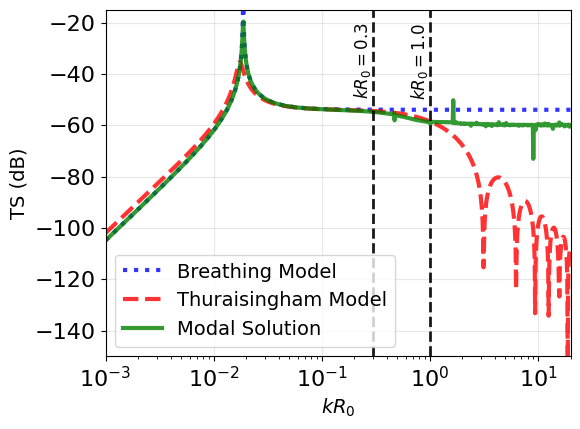

In [5]:
# Create plot of TS vs ka for three models
plt.figure(figsize=(6, 4.5))

# Full ka range comparison (0.001 to 20) - Raw TS values
plt.semilogx(ka, TS_breathing, 'b:', linewidth=3, label='Breathing Model', alpha=0.8)
plt.semilogx(ka, TS_thuraisingham, 'r--', linewidth=3, label='Thuraisingham Model', alpha=0.8) 
plt.semilogx(ka, TS_modal, 'g-', linewidth=3, label='Modal Solution', alpha=0.8)

# Add regime boundaries
plt.axvline(x=0.3, color='black', linestyle='--', alpha=0.9)
plt.text(0.3, -20, '$kR_0=0.3$', rotation=90, fontsize=12, ha='right', va='top', color='black')

plt.axvline(x=1.0, color='black', linestyle='--', alpha=0.9)
plt.text(1.0, -20, '$kR_0=1.0$', rotation=90, fontsize=12, ha='right', va='top', color='black')


plt.xlabel('$kR_0$', fontsize=14)
plt.ylabel('TS (dB)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)
plt.xlim(ka.min(), ka.max())
plt.ylim(-150, -15)  # Updated y-axis range
plt.tick_params(axis='both', which='major', labelsize=16)

# Save the plot to main plots folder
plot_file = PROJECT_ROOT / 'plots' / 'TS_non_dimensional.pdf'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ Plot saved to: {plot_file}")

plt.show()